In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('trip_count_sql').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/13 06:50:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/06/13 06:50:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/06/13 06:50:24 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/06/13 06:50:24 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
23/06/13 06:50:24 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [2]:
# 디렉토리 지정
# 여러 파일 한 번에 불러오기
directory = '/home/ubuntu/working/spark-examples/data'
trip_files = '/trips/*' # trips 폴더 내에 있는 모든 파일을 불러오기
zone_file = 'taxi+_zone_lookup.csv'

trips_df = spark.read.csv(f'file://{directory}/{trip_files}',
                         inferSchema = True,
                         header = True)

zone_df = spark.read.csv(f'file://{directory}/{zone_file}',
                        inferSchema = True,
                        header = True)




In [3]:
# Schema 확인
trips_df.printSchema()
zone_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [4]:
trips_df.first()

Row(VendorID=2, tpep_pickup_datetime='2021-03-01 00:22:02', tpep_dropoff_datetime='2021-03-01 00:23:22', passenger_count=1, trip_distance=0.0, RatecodeID=1, store_and_fwd_flag='N', PULocationID=264, DOLocationID=264, payment_type=2, fare_amount=3.0, extra=0.5, mta_tax=0.5, tip_amount=0.0, tolls_amount=0.0, improvement_surcharge=0.3, total_amount=4.3, congestion_surcharge=0.0)

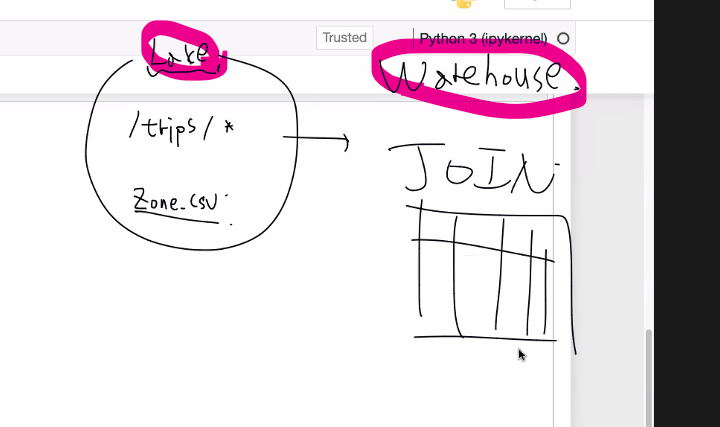
- 그냥 csv로 가져온 raw file들은 Data Lake이다.
- 이제 테이블끼리 JOIN을 통해 Data Warehouse로 가는 과정을 거칠 것
     - 우리가 쓸 것을 걸러내야 함.
     - trip, zone_df를 join해서 하나의 df로 만들어놓고 시작할 것

# Data Lake -> Data Warehouse

In [5]:
trips_df.createOrReplaceTempView('trips')
zone_df.createOrReplaceTempView('zone')

In [6]:
query = """
SELECT
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
    HOUR(t.tpep_pickup_datetime) as pickup_time,
    HOUR(t.tpep_dropoff_datetime) as dropoff_time,
    
    t.passenger_count,
    t.trip_distance,
    t.fare_amount,
    t.tip_amount,
    t.tolls_amount,
    t.total_amount,
    t.payment_type,
    
    pz.Zone as pickup_zone,
    dz.Zone as dropoff_zone
    
FROM trips t
LEFT JOIN
    zone pz
ON t.PULocationID = pz.LocationID 
LEFT JOIN
    zone dz
ON t.DOLocationID = dz.LocationID
"""

# join기준1 : 탑승지 기준
# join기준2 : 하차장소 기준 (Drop Off)

comb_df = spark.sql(query)
comb_df.createOrReplaceTempView('comb')


In [7]:
comb_df.show(5)

+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+-----------------+--------------+
|vendor_id|pickup_date|dropoff_date|pickup_time|dropoff_time|passenger_count|trip_distance|fare_amount|tip_amount|tolls_amount|total_amount|payment_type|      pickup_zone|  dropoff_zone|
+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+-----------------+--------------+
|        2| 2021-03-01|  2021-03-01|          0|           0|              1|          0.0|        3.0|       0.0|         0.0|         4.3|           2|               NV|            NV|
|        2| 2021-03-01|  2021-03-01|          0|           0|              1|          0.0|        2.5|       0.0|         0.0|         3.8|           2|   Manhattanville|Manhattanville|
|        2| 2021-03-01|  2021-03-01|          0|           0|    

In [12]:
comb_df.columns

['vendor_id',
 'pickup_date',
 'dropoff_date',
 'pickup_time',
 'dropoff_time',
 'passenger_count',
 'trip_distance',
 'fare_amount',
 'tip_amount',
 'tolls_amount',
 'total_amount',
 'payment_type',
 'pickup_zone',
 'dropoff_zone']

In [8]:
query  = """
SELECT pickup_date, pickup_time
FROM comb
WHERE pickup_time < '2020-12-31'
ORDER BY pickup_date
"""

spark.sql(query).show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2002-12-31|         23|
| 2003-01-05|          7|
| 2004-04-04|          4|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         22|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2008-12-31|         23|
+-----------+-----------+
only showing top 20 rows



In [9]:
# 요금 데이터 확인
comb_df.select('total_amount').describe().show()

+-------+-----------------+
|summary|     total_amount|
+-------+-----------------+
|  count|         15000700|
|   mean|18.75545205708744|
| stddev|145.7442452805979|
|    min|           -647.8|
|    max|         398469.2|
+-------+-----------------+



- min이 음수인 데이터 존재..? max가 4억..? 택시비 4억 말 절대 안됨 => 정제 필요

In [10]:
# 거리 데이터 확인
comb_df.select('trip_distance').describe().show()

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|         15000700|
|   mean|6.628629402627818|
| stddev|671.7293482115828|
|    min|              0.0|
|    max|        332541.19|
+-------+-----------------+



In [11]:
# 승객 수 데이터 확인
comb_df.select('passenger_count').describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          14166672|
|   mean|1.4253783104458126|
| stddev|  1.04432704905968|
|    min|                 0|
|    max|                 9|
+-------+------------------+



In [25]:
# null값 확인??

from pyspark.sql.functions import col, count, when

comb_df.select([count(when(col(c).isNull(), c)) for c in comb_df.columns]).show()


+-------------------------------------------------------+-----------------------------------------------------------+-------------------------------------------------------------+-----------------------------------------------------------+-------------------------------------------------------------+-------------------------------------------------------------------+---------------------------------------------------------------+-----------------------------------------------------------+---------------------------------------------------------+-------------------------------------------------------------+-------------------------------------------------------------+-------------------------------------------------------------+-----------------------------------------------------------+-------------------------------------------------------------+
|count(CASE WHEN (vendor_id IS NULL) THEN vendor_id END)|count(CASE WHEN (pickup_date IS NULL) THEN pickup_date END)|count(CASE WHEN (dropof

In [15]:
# 월 별 운행 수 확인
query = '''
        SELECT DATE_TRUNC("MM", c.pickup_date) AS month,
                COUNT(*) as trips
        FROM comb c
        GROUP BY month
        ORDER BY month desc
'''

In [16]:
spark.sql(query).show()

+-------------------+-------+
|              month|  trips|
+-------------------+-------+
|2029-05-01 00:00:00|      1|
|2021-12-01 00:00:00|      5|
|2021-11-01 00:00:00|      5|
|2021-10-01 00:00:00|      3|
|2021-09-01 00:00:00|      3|
|2021-08-01 00:00:00|     36|
|2021-07-01 00:00:00|2821430|
|2021-06-01 00:00:00|2834204|
|2021-05-01 00:00:00|2507075|
|2021-04-01 00:00:00|2171215|
|2021-03-01 00:00:00|1925130|
|2021-02-01 00:00:00|1371688|
|2021-01-01 00:00:00|1369749|
|2020-12-01 00:00:00|     16|
|2009-01-01 00:00:00|    111|
|2008-12-01 00:00:00|     26|
|2004-04-01 00:00:00|      1|
|2003-01-01 00:00:00|      1|
|2002-12-01 00:00:00|      1|
+-------------------+-------+



살펴본 내용을 토대로 실제 분석할 데이터로 정제. 
- **Warehouse -> Mart**
- cleaned_df = data mart

In [29]:
# Data 정제
query = """
    SELECT *
    FROM comb c
    WHERE c.total_amount < 5000
    AND c.total_amount > 0
    AND c.passenger_count < 5
    AND c.pickup_date >= '2021-01-01'
    AND c.pickup_date < '2021-08-01'
    
"""

cleaned_df = spark.sql(query)
cleaned_df.createOrReplaceTempView('cleaned')

In [30]:
cleaned_df.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+
|summary|         vendor_id|       pickup_time|      dropoff_time|   passenger_count|     trip_distance|       fare_amount|        tip_amount|      tolls_amount|      total_amount|      payment_type|         pickup_zone|        dropoff_zone|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+
|  count|          13499526|          13499526|          13499526|          13499526|          13499526|          13499526|          13499526|          13499526|          13499526|          13499526|            13499526|            13499526|
|   mean|1.6724006457708218|14.2

# 시각화

In [32]:
# !pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 48.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 70.6 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 68.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.0/300.0 kB 38.2 MB/s eta 0:00:00


In [34]:
# !pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 7.0 MB/s eta 0:00:00a 0:00:01


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
cleaned_df.columns

['vendor_id',
 'pickup_date',
 'dropoff_date',
 'pickup_time',
 'dropoff_time',
 'passenger_count',
 'trip_distance',
 'fare_amount',
 'tip_amount',
 'tolls_amount',
 'total_amount',
 'payment_type',
 'pickup_zone',
 'dropoff_zone']

In [42]:
# pickup_date 별 운행 수 확인

query = """
        SELECT pickup_date, count(pickup_date) as trips
        FROM cleaned
        GROUP BY pickup_date
"""

# 쿼리 실행 결과를 판다스 데이터프레임으로 바꿔서 시각화
pd_df = spark.sql(query).toPandas() # toPandas(): 액션
pd_df

,pickup_date,trips
0,2021-03-22,53031
1,2021-03-07,34865
2,2021-03-21,40258
3,2021-05-27,84245
4,2021-03-14,39323
...,...,...
207,2021-03-30,59434
208,2021-03-27,60760
209,2021-03-29,51334
210,2021-04-27,68779


Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


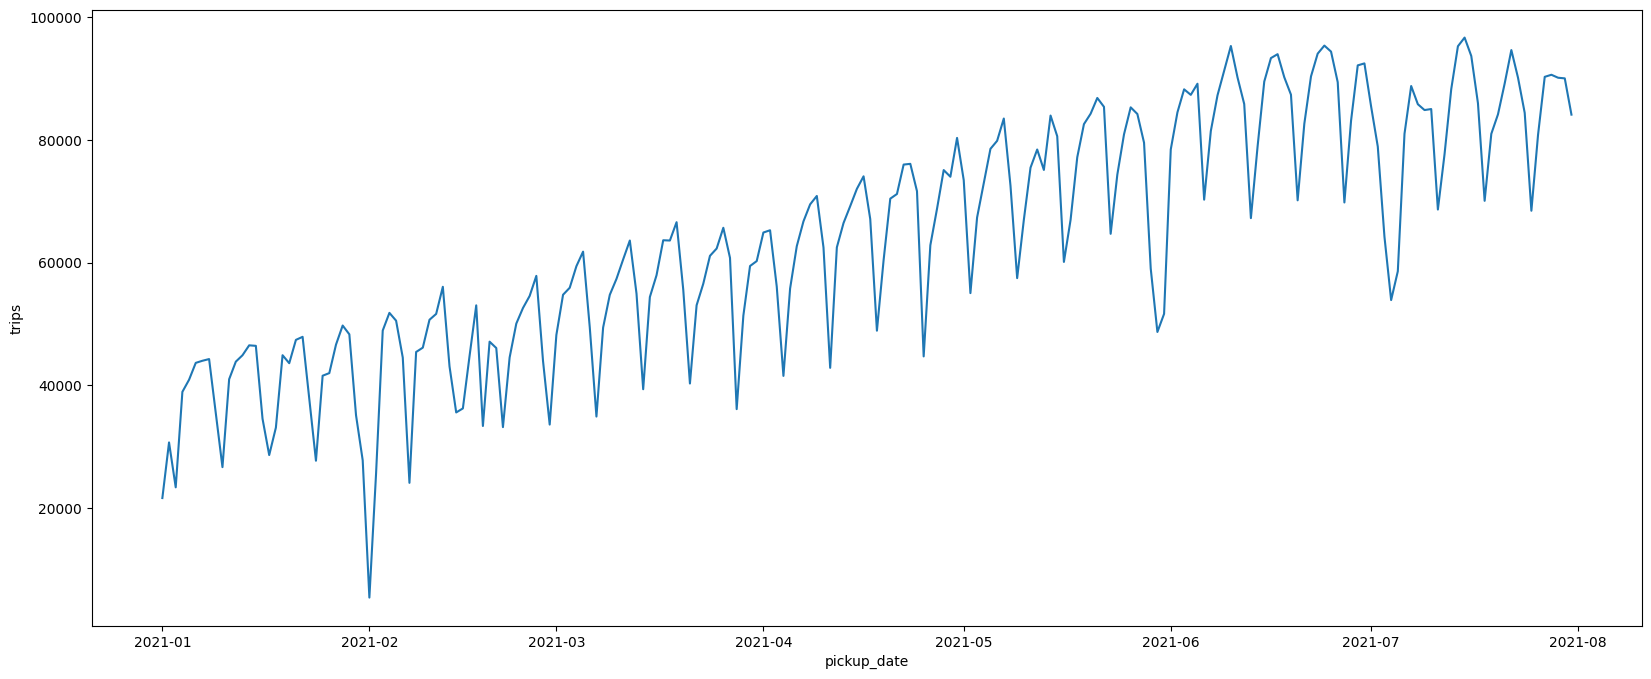

In [43]:
plt.subplots(figsize=(20,8))
sns.lineplot(x='pickup_date', y='trips', data=pd_df)
plt.show()

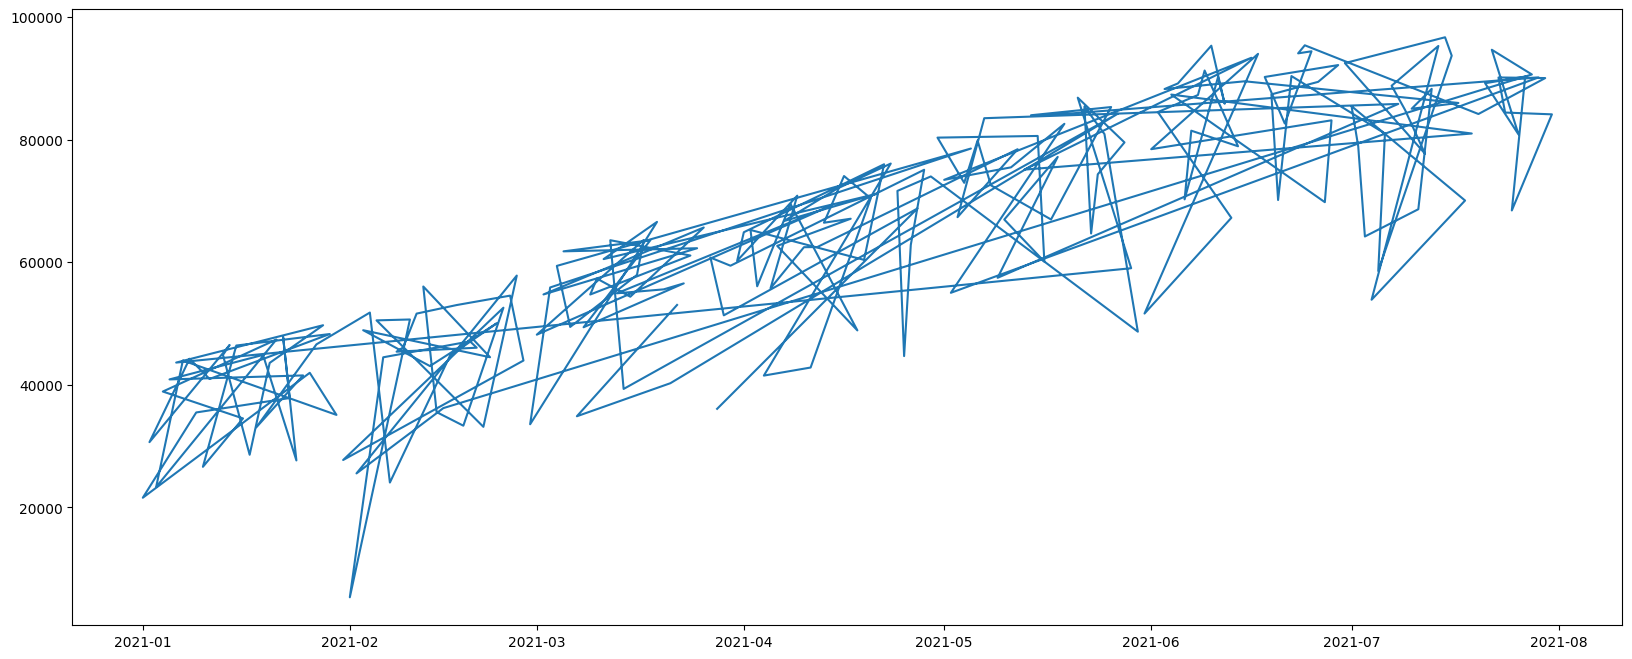

In [74]:
# ????????????
plt.subplots(figsize=(20,8))
plt.plot('pickup_date','trips', data=pd_df)

In [52]:
cleaned_df.columns

['vendor_id',
 'pickup_date',
 'dropoff_date',
 'pickup_time',
 'dropoff_time',
 'passenger_count',
 'trip_distance',
 'fare_amount',
 'tip_amount',
 'tolls_amount',
 'total_amount',
 'payment_type',
 'pickup_zone',
 'dropoff_zone']

In [57]:
# 요일 별 중간값 확인
query = """
    SELECT  pickup_date,
            DATE_FORMAT(pickup_date, 'EEEE') as day_of_week,
            count(*) as trips
    FROM cleaned
    GROUP BY pickup_date, day_of_week
"""

pd_df2 = spark.sql(query).toPandas()
pd_df2

,pickup_date,day_of_week,trips
0,2021-03-24,Wednesday,61095
1,2021-03-03,Wednesday,55886
2,2021-03-05,Friday,61779
3,2021-03-09,Tuesday,54732
4,2021-03-26,Friday,65675
...,...,...,...
207,2021-03-30,Tuesday,59434
208,2021-04-24,Saturday,71646
209,2021-03-28,Sunday,36076
210,2021-04-25,Sunday,44682


<Axes: xlabel='pickup_date', ylabel='trips'>

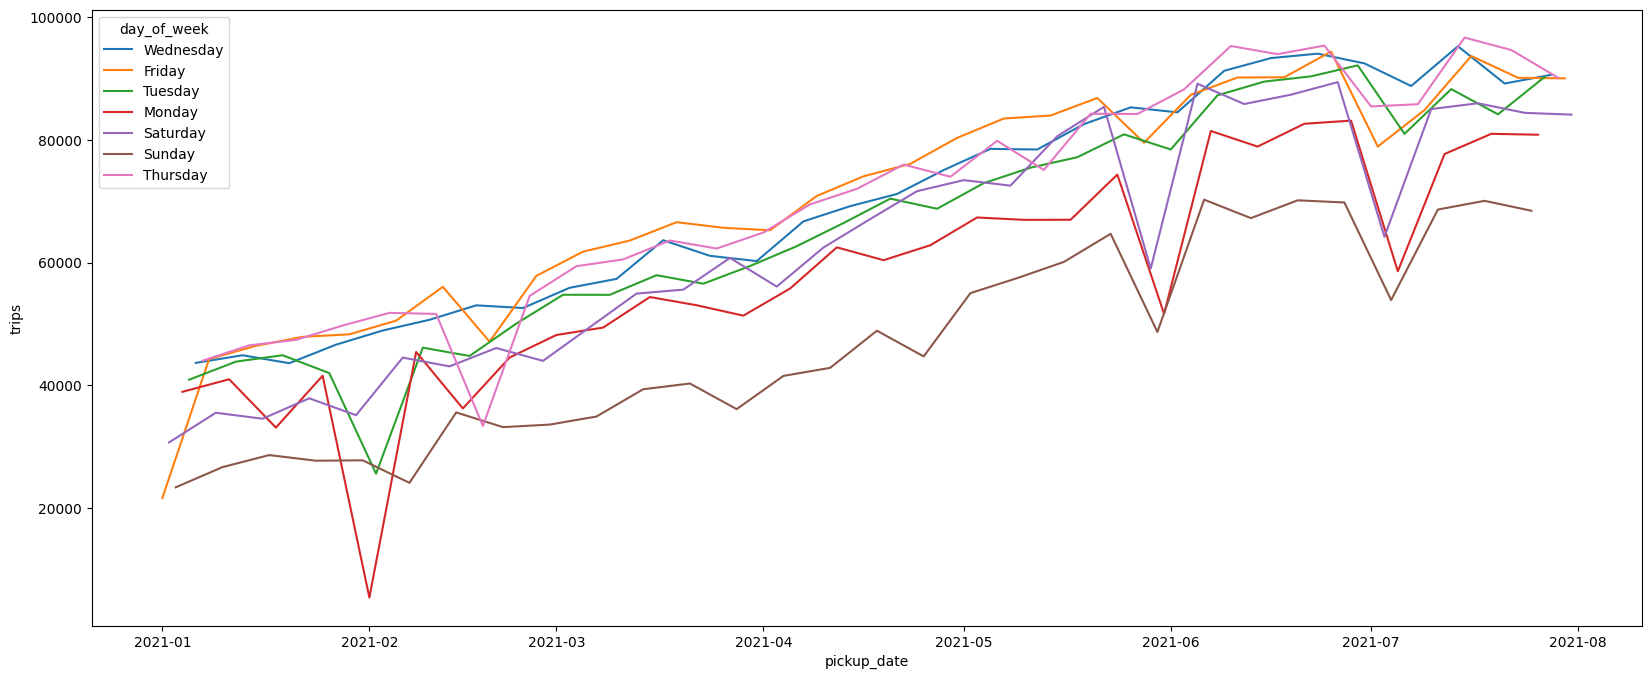

In [66]:
plt.subplots(figsize=(20,8))
sns.lineplot(x='pickup_date',y='trips',data=pd_df2, hue='day_of_week')

In [62]:
median_data = pd_df2.groupby('day_of_week')['trips'].median().to_frame()
median_data = median_data.reset_index()
median_data

,day_of_week,trips
0,Friday,74073.0
1,Monday,57168.5
2,Saturday,62455.0
3,Sunday,43749.0
4,Thursday,73015.0
5,Tuesday,67614.5
6,Wednesday,70196.0


In [63]:
# 요일 정렬(일월화수목금토)
median_data["sort_dow"] = median_data["day_of_week"].replace({
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
})
median_data

,day_of_week,trips,sort_dow
0,Friday,74073.0,5
1,Monday,57168.5,1
2,Saturday,62455.0,6
3,Sunday,43749.0,0
4,Thursday,73015.0,4
5,Tuesday,67614.5,2
6,Wednesday,70196.0,3


In [64]:
median_data = median_data.sort_values(by='sort_dow')
median_data

,day_of_week,trips,sort_dow
3,Sunday,43749.0,0
1,Monday,57168.5,1
5,Tuesday,67614.5,2
6,Wednesday,70196.0,3
4,Thursday,73015.0,4
0,Friday,74073.0,5
2,Saturday,62455.0,6


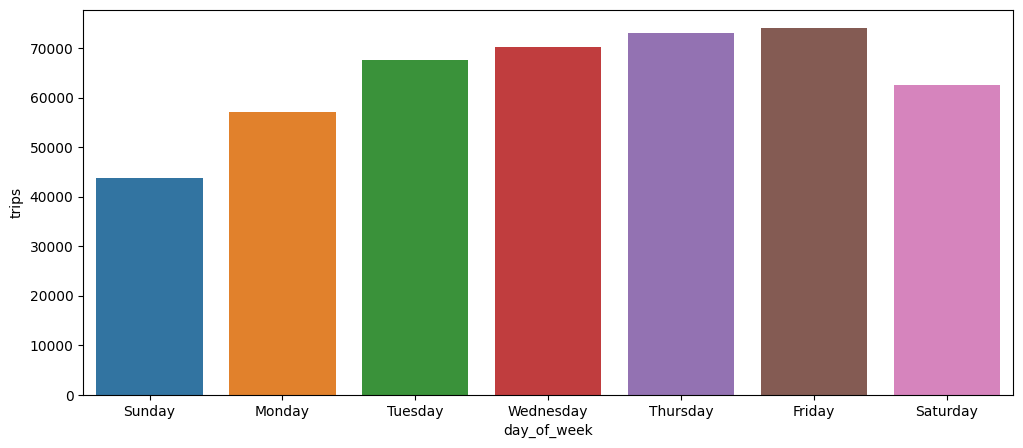

In [67]:
plt.figure(figsize=(12,5))
sns.barplot(
        x= 'day_of_week',
        y = 'trips',
        data = median_data)

plt.show()

<BarContainer object of 7 artists>

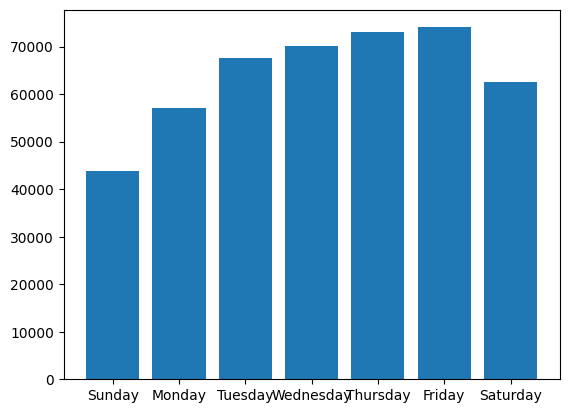

In [70]:
plt.bar('day_of_week', 'trips', data=median_data)

In [78]:
# 결제 유형 별 분석

payment_type_to_string = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip",
}


def parse_payment_type(payment_type):
    return payment_type_to_string[payment_type]

In [79]:
parse_payment_type(3)

'No Charge'

In [80]:
spark.udf.register('parse_payment_type',parse_payment_type)

<function __main__.parse_payment_type(payment_type)>

In [81]:
query = """
    SELECT parse_payment_type(payment_type),
            count(*) as trips,
            mean(fare_amount) as mean_fare_amount,
            std(fare_amount) as std_fare_amount
    FROM cleaned
    GROUP BY payment_type
"""

spark.sql(query).show()

+--------------------------------+--------+------------------+------------------+
|parse_payment_type(payment_type)|   trips|  mean_fare_amount|   std_fare_amount|
+--------------------------------+--------+------------------+------------------+
|                     Credit Card|10264367| 12.23131695895088|10.873451774072866|
|                       No Charge|   59145|11.978582804970836|15.075633897695056|
|                         Dispute|   23806|12.730067209947066|14.892785718894652|
|                            Cash| 3152207|12.020139365847463| 11.75093016994253|
|                         Unknown|       1|              17.8|              null|
+--------------------------------+--------+------------------+------------------+



In [82]:
spark.stop()